# Group Member

In [0]:
import pandas as pd
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from google.cloud import bigquery
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from scipy.stats import chisquare
import calendar
import math
import pickle

pd.set_option('display.max_columns', 500)
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./license/APMA4990-834091538ff1.json"

# colab setting
# ! gcloud init
project_id = 'bustling-folio-237814'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/content/BMEN4000-jw3689-ead9cbc97612.json'

# Data Gathering and Preparation

## Data Pipeline

- **Data Source: Big Query**

 We fetch data directly from Big Query: `bigquery-public-data.new_york.tlc_yellow_trips_2016`, allocated with `bigquery-public-data.noaa_gsod.gsod2016`, leaving out some useless or unreliable features: payment_type, fare_amount, extra, mta_tax, imp_surcharge, tip_amount, tolls_amount and total_amount from the original dataset. Then we add month, year, weekday, hour, trip duration and haversine distance as additional features.

- **Selected Features**
 
| Parameters  | Variables | Description  | Filter|
|---|---|---|---|
| **Pickup Latitude**  | pickup_latitude  | The latitude where the meter was engaged.  |in New York: 40~42. |
| **Pickup Longitude**  | pickup_longitude  | The longitude where the meter was engaged.  |in New York: -75~-73|
| **Dropoff Latitude**  | dropoff_latitude  | The latitude where the meter was disengaged.  |in New York: 40~42|
| **Dropoff Longitude**  | dropoff_longitude  | The longitude where the meter was disengaged.  |in New York: -75~-73|
| **Pickup Datetime**  | pickup_datetime  | Month, day, year, hour and weekday of when the meter was engaged. |/|
| **Dropoff Datetime**  | dropoff_datetime  | Month, day, year, hour and weekday of when the meter was disengaged. |/|
| **Passenger Count**  | passenger_count  | The number of passengers in the vehicle (driver entered value)  | normal capacity: 1~4  |
| **Month**  | month  | month of the pick up datetime. |/|
| **Year**  | year  | year of the pick up datetime. |2016|
| **Weekday**  | day  | month of the pick up datetime. |/|
| **Hour**  | hour  | hour of the pick up datetime. |/|

- **Calculated Features**

| Parameters  | Variables | Description  |Filter|
|---|---|---|---|
| **Haversine Distance (km)**  | hav_distance  | Great-circle distance between two points on a sphere, calculated with <br>pickup/dropoff latitude and longitude.  |relatively straight <br>forward rountine: 0.1~30|
| **Trip Duration (s)**  | trip_duration  | Duration of the trip in seconds, calculated with pickup datetime and <br>dropoff datetime.  | between one minute <br>and one hour: 60~3600|

 - **Supplemented Features - Weather**
(at Station 725053)

| Parameters  | Variables | Description  |Filter|
|---|---|---|---|
| **Temperature**  | temp, max, min  | Mean, maximum and minumum daily temperature.  |/|
| **Visibility**  | visib  | Mean visibility for the day in miles to tenths.  |/|
| **Wind**  | wdsp, gust  | Mean wind speed and maximum wind gust for the day in <br>knots to tenths.  |/|
|**Precipitation** |prcp, sndp|Total precipitation (rain and/or melted snow) reported during the day <br>in inches and hundredths; Snow depth in inches to tenths|/|
| **Indicators**  | fog, rain_drizzle,	thunder,	<br>snow_ice_pellets, hail  | (1 = yes, 0 = no/not reported) for the occurrence during the day. |/|

In [0]:
# Fetch data from big query
# No need if there is data file in local repository

client = bigquery.Client()

query = (
    """
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  6371 * 2 * ASIN(SQRT(x))
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
        COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
        POW(SIN(RADIANS(long1)/2 - RADIANS(long2)/2),2) +
        POW(SIN(RADIANS(lat1)/2 - RADIANS(lat2)/2),2))
);
    
    SELECT * FROM 
    (
        SELECT pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,
        EXTRACT (DATE FROM pickup_datetime) as date,
        EXTRACT (MONTH FROM pickup_datetime) as month,
        EXTRACT (DAYOFWEEK FROM pickup_datetime) as day,
        EXTRACT (YEAR FROM pickup_datetime) as year,
        EXTRACT (HOUR from pickup_datetime) as hour,
        HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) as hav_distance,
        TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) as trip_duration
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        
        WHERE pickup_longitude BETWEEN -75 AND -73
        AND dropoff_longitude BETWEEN -75 AND -73
        AND pickup_latitude BETWEEN 40 AND 42
        AND dropoff_latitude BETWEEN 40 AND 42
        AND HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) BETWEEN 0.1 AND 30
        AND passenger_count BETWEEN 1 AND 4
        AND TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) BETWEEN 60 AND 3600
    ) trip
    INNER JOIN
    (
     SELECT CONCAT(year,'-',mo,'-',da) as date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     FROM `bigquery-public-data.noaa_gsod.gsod2016` 
     WHERE stn = '725053'
    ) weather
    on CAST(trip.date AS STRING) = weather.date2
    
    ORDER BY RAND()
    LIMIT 1000000
    """
)

df = pd.io.gbq.read_gbq(query, project_id, dialect='standard')
df['wdsp'] = df['wdsp'].astype(float,copy=True,errors='raise')

- **Fetch New Data and Retrain Model**

 It is easy for our pipeline to fetch new data and retrain the model. Firstly, BigQuery allows using SQL without the need for a database administrator. Secondly, since the query is integreted and the code shuffles data randomly, a new dataset is acquired everytime we rerun the cell. Additionaly, we offer to write data into a local csv file, so we can restore different files of randomly selected datasets. Once we want to retrain the model with new dataset, the only thing to do is changing the csv file path.

In [0]:
# df.to_csv('data.csv',index=False)
df = pd.read_csv('data.csv')

In [5]:
df.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,month,day,year,hour,hav_distance,trip_duration,date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-03-19 17:46:04,2016-03-19 17:59:03,-73.977585,40.753319,-73.986824,40.766708,2,2016-03-19,3,7,2016,17,1.679950,779,2016-03-19,42.3,10.0,4.1,15.0,57.0,36.0,0.00,999.9,0,0,0,0,0
1,2016-02-24 14:35:00,2016-02-24 15:00:02,-73.955070,40.765083,-73.990929,40.750107,2,2016-02-24,2,4,2016,14,3.448939,1502,2016-02-24,40.7,2.9,11.0,31.1,55.9,35.1,0.43,999.9,0,1,0,0,0
2,2016-04-07 07:35:29,2016-04-07 07:44:51,-74.000580,40.737328,-73.985725,40.752369,3,2016-04-07,4,5,2016,7,2.088856,562,2016-04-07,52.4,9.3,5.8,22.9,57.9,30.0,0.00,999.9,0,1,0,0,0
3,2016-04-17 19:59:38,2016-04-17 20:05:19,-73.976303,40.759174,-73.967468,40.752888,1,2016-04-17,4,1,2016,19,1.020993,341,2016-04-17,56.1,10.0,2.3,999.9,75.0,43.0,0.00,999.9,0,0,0,0,0
4,2016-02-05 22:08:48,2016-02-05 22:13:00,-73.989830,40.767464,-73.973343,40.762630,1,2016-02-05,2,6,2016,22,1.488896,252,2016-02-05,37.4,6.1,7.4,25.1,48.9,30.2,0.38,999.9,1,1,1,0,0


In [6]:
df.shape

(1000000, 28)

In [0]:
# # Modify into the format of Website data:
# webdata = df[['pickup_datetime','pickup_latitude','pickup_longitude']]
# webdata.to_csv('webdata.csv',index=True)

## Data Integrity Check

- **Check Missing Values and Outliner**
 - check if there is NAN data.
 - check if indicators are binary.
 - check whether the year is 2016 or not.
 - check the reliability if weather features.

In [10]:
check_NAN_box = []

for i in df.columns:
    check_NAN_box.append(df[i].isnull().any())

check_NAN_box = pd.DataFrame([check_NAN_box],columns=df.columns)
np.unique(check_NAN_box.values)

array([False])

In [11]:
check_uni_box = []
col = ['year','fog','rain_drizzle','snow_ice_pellets','hail','thunder']

for i in col:
    check_uni_box.append(df[i].unique())

check_uni_box = pd.DataFrame([check_uni_box],columns=col)
check_uni_box

,year,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,[2016],"[0, 1]","[0, 1]","[0, 1]",[0],[0]


In [12]:
check_miss_box = []
col = ['temp','visib','wdsp','gust','max','min','prcp','sndp']
miss = [9999.9,999.9,999.9,999.9,9999.9,9999.9,99.99,999.9]

for i in range(len(col)):
    check_miss_box.append((df[col[i]]==miss[i]).sum())
    
check_miss_box = pd.DataFrame([check_miss_box],columns=col)
check_miss_box

,temp,visib,wdsp,gust,max,min,prcp,sndp
0,0,23310,28873,282660,0,0,0,945147


- **Results:**

 Based on the results, there are no NAN entries in the dataset and typological data are all in reasonable types. As for other weather features, It looks like *sndp* has many missing entries, so we will not use it as reliable feature.
 
- **Consider Information Leakage**

 The applied features do not include information of the outcome. The calculation does not involve use of outcomes; also, we can verify this in further correlation analysis.
 
- **Check Non-sensical or Redundant Variables**

 There is no redundant variables. (to be supplemented...)

## Feature Engineering

- **Transform Lat/Lon Variables to Distance**
 - **Haversine Distance:** Great-circle distance between two points on a sphere, calculated with pickup/dropoff latitude and longitude.
 - **Euclidian Distance:** Straight-line distance between two points in Euclidean space, calculated with pickup/dropoff latitude and longitude.
 - **Manhattan Distance:** The sum of the horizontal and vertical distances between points on a grid.

In [0]:
# Haversine distance
def hav_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Euclidean distance
def euc_distance(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    e = math.sqrt((AVG_EARTH_RADIUS * (lat1-lat2))**2+(AVG_EARTH_RADIUS * (lng1-lng2))**2)
    return e

# Manhattan distance
def man_distance(lat1,lng1,lat2,lng2):
    a = hav_distance(lat1, lng1, lat1, lng2)
    b = hav_distance(lat1, lng1, lat2, lng1)
    return a + b

- **Making New Powerful Variables - PCA:** 
 - Pickup/dropoff latitude and longitude are coordinates, which are not numerical features in training models, so we have to apply some trasformations.
  - To extract  latent space projections, finding out a 2D lower dimensional  representative of 4D features, so that two pairs of pickup and dropoff longitude and latitude can be represented as a pair of inputs.
 - We stack pickup/dropoff latitude and longitude in a matrix and apply pca on it to get main components concerned with relationship between pickup and dropoff locations.

In [0]:
# Not to use data
no_use = ['pickup_datetime','dropoff_datetime','date','date2','year',
          'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','sndp']

- **Define Preprocessing Function:** 

 - Help avoid repeating code.
  - Clean up terms of data with missing values and replace them by mean value.
 - Calculate three types of distance: haversine distance, euclidean distance, manhattan distance.
 - Convert some of the features to numerical types. 

In [0]:
def preprocess(data):    
    # Convert multi-class label to one-hot value
    tmp = pd.get_dummies(data = data,columns=['month','day','hour'])
    
    # Replace samples of no record with mean value
    mean_tmp = np.mean([item for item in tmp['temp'] if item != 9999.9])
    tmp['temp'] = tmp['temp'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['visib'] if item != 999.9])
    tmp['visib'] = tmp['visib'].replace(999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['wdsp'] if item != 999.9])
    tmp['wdsp'] = tmp['wdsp'].replace(999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['gust'] if item != 999.9])
    tmp['gust'] = tmp['gust'].replace(999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['max'] if item != 9999.9])
    tmp['max'] = tmp['max'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['min'] if item != 9999.9])
    tmp['min'] = tmp['min'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['prcp'] if item != 99.99])
    tmp['prcp'] = tmp['prcp'].replace(999.9,mean_tmp)
    
    # PCA of coordinates
    pca = PCA(n_components=2)
    pca_matrix = pca.fit_transform(tmp[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].values)
    tmp['pca0'] = pca_matrix[:,0]
    tmp['pca1'] = pca_matrix[:,1]
    
    # Convert binary labels to numerical labels
    tmp['fog'] = tmp['fog'].astype(int,copy=True,errors='raise')
    tmp['rain_drizzle'] = tmp['rain_drizzle'].astype(int,copy=True,errors='raise')
    tmp['snow_ice_pellets'] = tmp['snow_ice_pellets'].astype(int,copy=True,errors='raise')
    tmp['hail'] = tmp['hail'].astype(int,copy=True,errors='raise')
    tmp['thunder'] = tmp['thunder'].astype(int,copy=True,errors='raise')
    
    hav = []
    euc = []
    man = []
    lat1 = tmp['pickup_latitude'].values
    lng1 = tmp['pickup_longitude'].values
    lat2 = tmp['dropoff_latitude'].values
    lng2 = tmp['dropoff_longitude'].values
    for i in range(len(tmp)):
        hav.append(hav_distance(lat1[i],lng1[i],lat2[i],lng2[i]))
        euc.append(euc_distance(lat1[i],lng1[i],lat2[i],lng2[i]))
        man.append(man_distance(lat1[i],lng1[i],lat2[i],lng2[i]))
    tmp['hav_distance'] = hav
    tmp['euc_distance'] = euc
    tmp['man_distance'] = man
    
    feature_names = [f for f in tmp.columns if f not in no_use]
    
    return tmp[feature_names]

In [16]:
data = preprocess(df)
data.shape

(1000000, 56)

In [17]:
data.dtypes

passenger_count       int64
hav_distance        float64
trip_duration         int64
temp                float64
visib               float64
wdsp                float64
gust                float64
max                 float64
min                 float64
prcp                float64
fog                   int64
rain_drizzle          int64
snow_ice_pellets      int64
hail                  int64
thunder               int64
month_1               uint8
month_2               uint8
month_3               uint8
month_4               uint8
month_5               uint8
month_6               uint8
day_1                 uint8
day_2                 uint8
day_3                 uint8
day_4                 uint8
day_5                 uint8
day_6                 uint8
day_7                 uint8
hour_0                uint8
hour_1                uint8
hour_2                uint8
hour_3                uint8
hour_4                uint8
hour_5                uint8
hour_6                uint8
hour_7              

- We didn't join the data to any other interesting data sets(?????)

# Model Selection, Comparison and Cross Validation

## Exploratory Analysis

### Trip distance and duration distribution

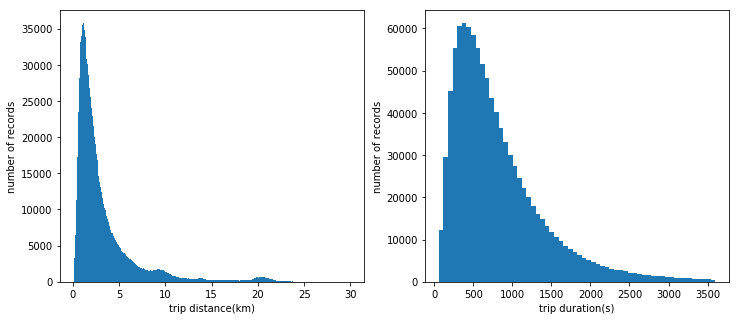

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist(data['hav_distance'].values, bins=300)
ax[0].set_xlabel('trip distance(km)')
ax[0].set_ylabel('number of records')

ax[1].hist(data['trip_duration'].values, bins=60)
ax[1].set_xlabel('trip duration(s)')
ax[1].set_ylabel('number of records')

plt.show()

In [0]:
# # To have a look at the values of histgrams
# for a,b in enumerate(patches):
#     print('Histgram values of trip distance', a,b)
# for a,b in enumerate(patches_):
#     print('Histgram values of trip duration',a,b)

**Observations:**
- If we have a look at the histgram of our preprocessed data, the shape of either distribution is similar to a gamma distribution. 
- The most frequent distance of the trip is around 1km, rougly distributed within range of 0 to 5 km; and most frequent trip duration is around 400s, roughly distributed within range of 100 to 1500 s.
- Based on the trend displayed by these two pictures, it is save to say that our filter in query process successfully avoid outliers.

[Text(0, 0.5, 'Trip Duration(s)'), Text(0.5, 0, 'Haversine Distance(km)')]

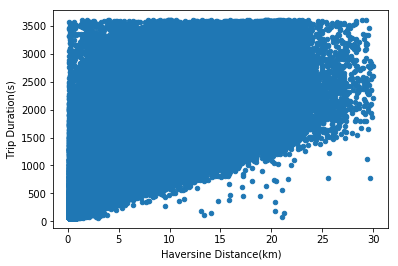

In [19]:
ax_ = data.plot(x='hav_distance',y='trip_duration',kind='scatter')
ax_.set(xlabel='Haversine Distance(km)',ylabel='Trip Duration(s)')

**Observations:**
- The scatter plot is an approximate banding pattern. The region with more densely clustered points represents the general cases. When distance is below around 24km, the points are dense, when distance is above around 24km, the points become sparse.
- The trip duration is linearly and positively correlated with Haversine distance. The bottom of scatter is roughly linear with slope 0.015km/s (55.2km/h), which might indicate that the there exists a upper limit of speed of travelling. The upper boundary seems blurred, which might imply various non-straight-forward routine.

### Correlation

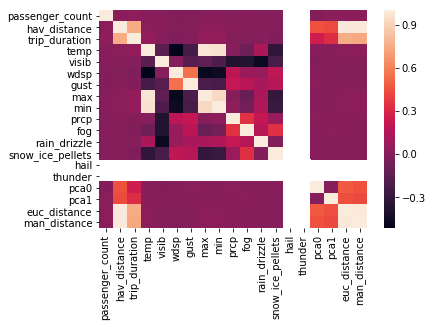

In [23]:
tmp = data[data.columns[data.dtypes!='uint8']]
tmp = tmp[tmp.columns[tmp.dtypes!='int32']]

corr = tmp.corr()
from scipy.stats import chisquare
sns.heatmap(corr)  # Correlation map for continuous features

In [24]:
tmp = data[data.columns[data.dtypes!='float64']]
tmp = tmp[tmp.columns[tmp.dtypes!='int64']]

frequency = []

for name in tmp.columns:
    frequency.append(tmp[name][tmp[name]==1].sum())
    
pd.DataFrame([frequency], columns=tmp.columns)

,month_1,month_2,month_3,month_4,month_5,month_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,156459,164120,175955,171491,171306,160669,133504,129907,139106,144217,149070,153166,151030,36190,26198,19152,14088,10608,10410,22440,38410,46013,46492,44922,46358,49133,49293,50673,48621,43641,52616,62459,62280,58301,57974,55925,47803


In [25]:
chisquare(frequency)

Power_divergenceResult(statistic=1414006.2551226665, pvalue=0.0)

**Observations:**
- The most correlated features are 3 'distance' and 2 'pca'.
- Many features of the weather data have obvious correlations with one another.

### Trip Frequency

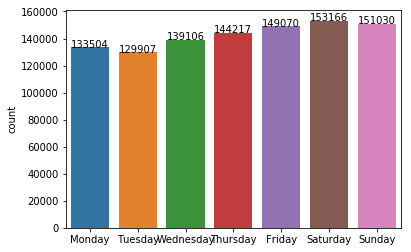

In [26]:
weekDays = {1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday",7:"Sunday"}

tmp = df['day'].sort_values()
days = [weekDays[i] for i in tmp]
ax = sns.countplot(days)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x(), p.get_height()))

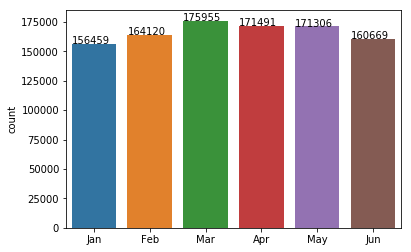

In [27]:
Months = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
          7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}

tmp = df['month'].sort_values()
months = [Months[i] for i in tmp]
ax = sns.countplot(months)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x(), p.get_height()))

**Observations:**
- Data for both weekday and month are almost evenly distributed. 
- For month information, there is only data from January to June, so we have to figure out ways to cover 12 months.

### Start and end point distribution

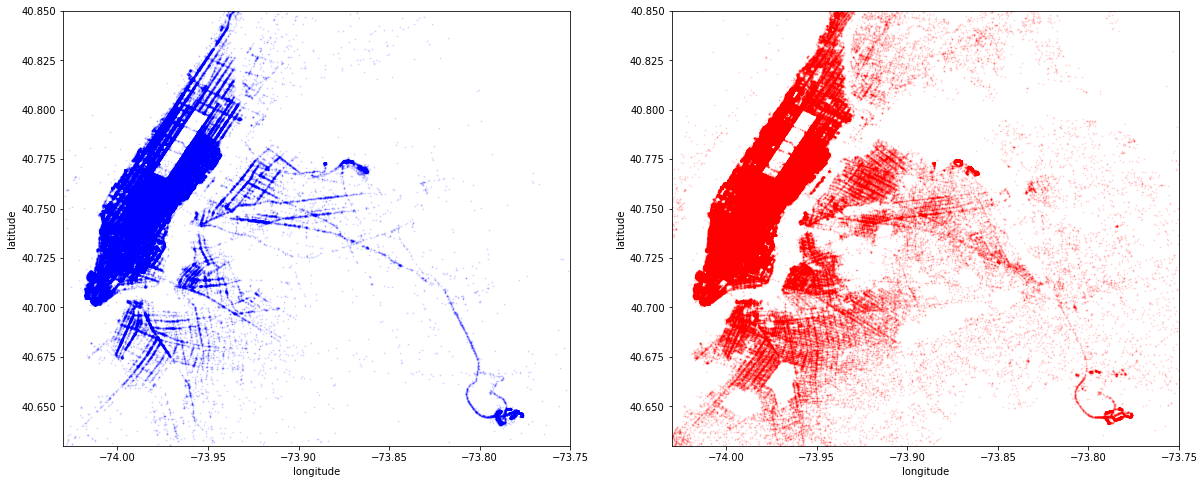

In [28]:
plt.figure(figsize=(20,8))
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.subplot(121)
plt.scatter(df['pickup_longitude'].values, df['pickup_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.subplot(122)
plt.scatter(df['dropoff_longitude'].values, df['dropoff_latitude'].values,
              color='red', s=1, alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

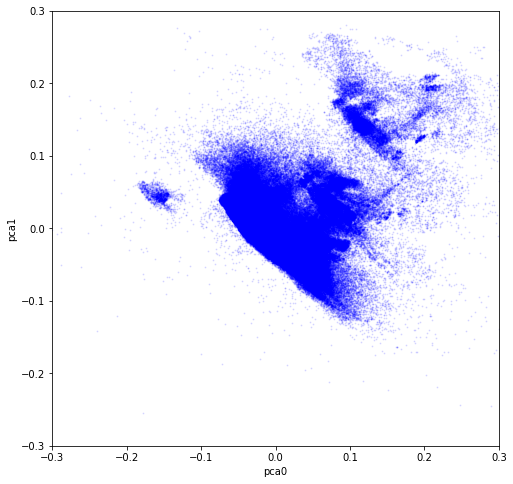

In [29]:
x_border = (-0.3, 0.3)
y_border = (-0.3, 0.3)

plt.figure(figsize=(8,8))
plt.scatter(data['pca0'].values, data['pca1'].values,
            color='blue', s=1, alpha=0.1)
plt.ylabel('pca1')
plt.xlabel('pca0')
plt.ylim(y_border)
plt.xlim(x_border)
plt.show()

**Observations:** 
- From scatter plot, the most popular fetch areas are Manhattan and two airports.
- From principle component analysis, the first two main components, pca0 and pca1 are no longer correlated with coordinates.

## Model Selection

- **Overview**

|Model|Regularization|R2|RMSE|RMSLE|
|---|---|---|---|---|
|**XGBoost**|L1, L2|0.776745|275.740445|0.357451|
|**Linear Regression**|L1|0.640532|349.888964|0.476842|
|**Random Forest**||0.654991|342.29541|0.429305|

- **Spliting Dateset and Rescaling**
 - $Training: Testing =0.8:0.2$
 - k-fold cross validation, $k=3$

In [0]:
scale_cols = data.columns[data.dtypes=='float64']

Y = data['trip_duration']

X = data.copy()
X[scale_cols] = preprocessing.scale(X[scale_cols])
X = X.drop('trip_duration',axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [31]:
X.columns  # features for training and prediction

Index(['passenger_count', 'hav_distance', 'temp', 'visib', 'wdsp', 'gust',
       'max', 'min', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail',
       'thunder', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'pca0', 'pca1',
       'euc_distance', 'man_distance'],
      dtype='object')

### XGBoost

- **Model Features:**
 - Gradient Boosting algorithm. 
 - Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
 - Regularized Gradient Boosting with both L1 and L2 regularization.

In [0]:
'''
Root Mean Squared Logarithmic Error (RMSLE):
If both real and predicted values are huge, RMSLE 
avoid penalizing huge differences between their values.
'''

def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0:
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [0]:
xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": np.arange(0.1,0.5,0.05),
    "gamma": np.arange(0.1,1,0.1),
    "learning_rate": np.arange(0.1,0.5,0.05),
    "max_depth": np.arange(2,10,1),
    "n_estimators": np.arange(50,150,10),
    "subsample": np.arange(0.1,1,0.1)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=0, n_iter=20, cv=3, verbose=1, 
                            n_jobs=-1, return_train_score=True)

search.fit(X_train, Y_train)

In [0]:
# Predict and calculate three types of error

Y_pred = search.predict(X_test)
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

In [0]:
xgb.plot_importance(search.best_estimator_,max_num_features=20,height=1)  # Plot feature importance

In [0]:
pickle.dump(search.best_estimator_, open('xgb_model', 'wb'))

- **Observations**
 - For XGBoost, we applied feature importance plot using F-score to show the importance of different features for current model.
 - After training, the model weighs more on Haversine and Manhattan distance, then goes the PCA features and Euclidian distance.

### Linear Regression

- **L1 Regularization:** To perform both variable selection and regularization.

In [0]:
linear_model = Lasso()

params = {
    "alpha": np.arange(0.01,0.5,0.01)
}

search = RandomizedSearchCV(linear_model, param_distributions=params, random_state=0, n_iter=10, cv=3, verbose=1, 
                            n_jobs=-1, return_train_score=True)

search.fit(X_train, Y_train)

,R2,RMSE,RMSLE
0,0.632128,355.901929,0.484851


In [0]:
# Predict and calculate three types of error

Y_pred = search.predict(X_test)
Y_test = Y_test
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

In [0]:
pickle.dump(search.best_estimator_, open('l1_model', 'wb'))  # save model

### Random Forest Model

In [0]:
rf_model = RandomForestRegressor()

params = {
    "n_estimators" = np.arange(50,150,10)
    "max_depth" = np.arange(2,10,1)
}

search = RandomizedSearchCV(rf_model, param_distributions=params, random_state=0, n_iter=10, cv=3, verbose=1, 
                            n_jobs=-1, return_train_score=True)

search.fit(X_train, Y_train)

,R2,RMSE,RMSLE
0,0.655288,344.516421,0.428923


In [0]:
Y_pred = search.predict(X_test)
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

In [0]:
pickle.dump(search.best_estimator_, open('rf_model', 'wb'))

In [0]:
loaded_model = pickle.load(open('rf_model', 'rb'))

# Prediction

## Prepare weather data and test data

In [0]:
# Fetch data from big query
# No need if there is data file in local repository

client = bigquery.Client()

query = (
    """
    SELECT CONCAT(year,'-',mo,'-',da) as date,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
    FROM `bigquery-public-data.noaa_gsod.gsod2015` 
    WHERE stn = '725053'
    """
)

weather = pd.io.gbq.read_gbq(query,project_id,dialect='standard')
weather['wdsp'] = weather['wdsp'].astype(float,copy=True,errors='raise')

In [0]:
weather.to_csv('weather.csv',index=False)
weather = pd.read_csv('weather.csv')

In [39]:
weather.head()

,date,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2015-03-10,47.2,8.5,3.3,14.0,54.0,39.0,0.13,13.0,0,1,0,0,0
1,2015-12-31,46.5,5.4,3.0,999.9,48.0,45.0,0.19,999.9,0,1,0,0,0
2,2015-11-30,39.4,999.9,6.0,999.9,44.6,33.8,0.00,999.9,0,0,0,0,0
3,2015-01-07,20.7,9.7,9.5,29.9,23.0,15.1,0.05,999.9,0,0,0,0,0
4,2015-01-15,29.5,10.0,3.6,999.9,34.0,25.0,0.00,999.9,0,0,0,0,0


In [40]:
weather['date'].nunique()

365

In [42]:
test = pd.read_csv('test.csv')
test.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5
1,2015-02-04 18:12:51+00:00,40.763245,-73.992752,40.801430,-73.948372,2
2,2015-01-05 22:15:39+00:00,40.755505,-73.975273,40.746243,-73.979782,1
3,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1
4,2015-10-21 04:27:55+00:00,40.759220,-73.980789,40.762402,-73.986458,1


In [0]:
def merge(test,weather):
    tmp = test.copy()
    date_time = pd.to_datetime(tmp['pickup_datetime'])
    
    date = date_time.dt.date
    date = [str(day) for day in date]
    month = date_time.dt.month
    month = month.map({1:1,2:2,3:3,4:4,5:5,6:6,7:6,8:5,9:4,10:3,11:2,12:1})
    day = date_time.dt.weekday+1
    hour = date_time.dt.hour
    
    mean_tmp = np.mean([item for item in tmp['pickup_latitude'] if item != 0.0])
    tmp['pickup_latitude'] = tmp['pickup_latitude'].replace(0.0,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['pickup_longitude'] if item != 0.0])
    tmp['pickup_longitude'] = tmp['pickup_longitude'].replace(0.0,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['dropoff_latitude'] if item != 0.0])
    tmp['dropoff_latitude'] = tmp['dropoff_latitude'].replace(0.0,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['dropoff_longitude'] if item != 0.0])
    tmp['dropoff_longitude'] = tmp['dropoff_longitude'].replace(0.0,mean_tmp)
    
    tmp['date2'] = date
    tmp['month'] = month
    tmp['day'] = day
    tmp['hour'] = hour
    
    tmp = tmp.merge(weather,how = 'left',left_on='date2',right_on='date')
    
    return tmp

In [44]:
test_data = merge(test,weather)
test_data = preprocess(test_data)
test_data.shape

(197706, 55)

In [45]:
test_data = test_data[X.columns]
test_data.head()

,passenger_count,hav_distance,temp,visib,wdsp,gust,max,min,prcp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,month_1,month_2,month_3,month_4,month_5,month_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pca0,pca1,euc_distance,man_distance
0,5,8.055939,66.8,9.8,3.3,20.050236,71.1,64.0,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.056370,0.010862,8.203417,9.651605
1,2,5.656060,31.2,9.1,4.0,14.000000,42.1,12.9,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.009374,0.058935,6.510085,7.983718
2,1,1.097702,40.9,9.7,9.7,40.000000,55.9,28.9,0.12,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.022383,-0.000885,1.145454,1.409689
3,1,12.587349,51.9,10.0,4.0,19.000000,55.9,46.0,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011391,0.077972,13.355402,16.652847
4,1,0.594214,65.0,9.9,2.8,15.000000,75.9,48.0,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.029991,0.009784,0.722811,0.831207


In [0]:
test_data_scale = test_data.copy()
test_data_scale[scale_cols] = preprocessing.scale(test_data_scale[scale_cols])

xgb_model = pickle.load(open('xgb_model', 'rb'))
prediction = xgb_model.predict(test_data_scale)

In [0]:
pd.DataFrame(prediction).to_csv('xgb_prediction.csv',index=False)

In [0]:
plt.figure(figsize=(12,5))
plt.subplot(121)
tmp = test_data['hav_distance'].values
plt.hist(tmp[tmp <= 30], bins=300)
plt.xlabel('trip distance(km)')
plt.ylabel('number of records')
plt.xlim((0.1,30))

plt.subplot(122)
plt.hist(prediction[prediction <= 3600], bins=60)
plt.xlabel('trip duration(s)')
plt.ylabel('number of records')
plt.xlim((60,3600))
plt.show()

In [0]:
l1_model = pickle.load(open('l1_model', 'rb'))
prediction = l1_model.predict(test_data_scale)
prediction.to_csv('l1_prediction.csv',index=False)

In [0]:
pd.DataFrame(prediction).to_csv('l1_prediction.csv',index=False)

In [0]:
plt.figure(figsize=(12,5))
plt.subplot(121)
tmp = test_data['hav_distance'].values
plt.hist(tmp[tmp <= 30], bins=300)
plt.xlabel('trip distance(km)')
plt.ylabel('number of records')
plt.xlim((0.1,30))

plt.subplot(122)
plt.hist(prediction[prediction <= 3600], bins=60)
plt.xlabel('trip duration(s)')
plt.ylabel('number of records')
plt.xlim((60,3600))
plt.show()

In [0]:
rf_model = pickle.load(open('rf_model', 'rb'))
prediction = rf_model.predict(test_data_scale)

In [0]:
pd.DataFrame(prediction).to_csv('rf_prediction.csv',index=False)

In [0]:
plt.figure(figsize=(12,5))
plt.subplot(121)
tmp = test_data['hav_distance'].values
plt.hist(tmp[tmp <= 30], bins=300)
plt.xlabel('trip distance(km)')
plt.ylabel('number of records')
plt.xlim((0.1,30))

plt.subplot(122)
plt.hist(prediction[prediction <= 3600], bins=60)
plt.xlabel('trip duration(s)')
plt.ylabel('number of records')
plt.xlim((60,3600))
plt.show()